# Qu: demo segmentation notebook

## Set up and import

In [1]:
# Import relevant modules
from pathlib import Path

import matplotlib.pyplot as plt
from tifffile import imread
import torch

from qu.data import DataManager
from qu.ml import UNet2DSegmenter
from qu.ml import UNet2DSegmenterSettings
from qu.demo import get_demo_segmentation_dataset

## Prepare the data and the model

In [2]:
# Get the demo dataset
data_root_path = get_demo_segmentation_dataset()
print(data_root_path)

# Set the working dir
working_dir = data_root_path

/home/aaron/.qu/data/demo_segmentation


In [3]:
# Notice: you can point tensorboard to ${data_root_path}.

In [4]:
# Scan for data
dataManager = DataManager()
dataManager.root_data_path = data_root_path
dataManager.scan()

True

In [8]:
# Report on the experiment type
print(f"Experiment type = {dataManager.experiment_type}")

Experiment type = ExperimentType.CLASSIFICATION


In [9]:
# Split images into training, validation and test set
train_image_names, train_mask_names, \
val_image_names, val_mask_names, \
test_image_names, test_mask_names = dataManager.training_split()

In [10]:
# Report split
print(f"Split: {len(train_image_names)}/{len(val_image_names)}/{len(test_image_names)}")

Split: 67/18/5


Text(0.5, 0, '0 = background, 1 = cell, 2 = border')

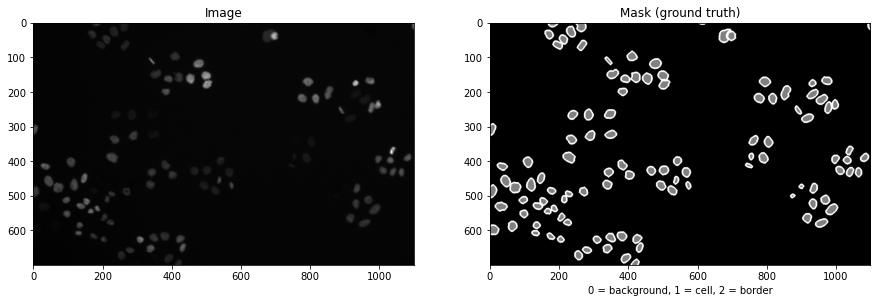

In [11]:
# Show an example pair
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax1.imshow(imread(train_image_names[0]), cmap='gray')
ax1.set_title("Image")
ax2.imshow(imread(train_mask_names[0]), cmap='gray')
ax2.set_title("Mask (ground truth)")
ax2.set_xlabel("0 = background, 1 = cell, 2 = border")

## Set up the Learner

In [12]:
# Check
print(f"Number of classes found in mask data: {dataManager.num_classes}")
print(f"Mask type estimated from mask data: {dataManager.mask_type}")

Number of classes found in mask data: 3
Mask type estimated from mask data: MaskType.TIFF_LABELS


In [13]:
# Initialize the settings
settings = UNet2DSegmenterSettings()

In [14]:
# Change some settings from their default values
settings.roi_size = (512, 512)
settings.batch_sizes = (8, 1, 1, 1)
settings.num_epochs = 400

In [15]:
# Get the settings as dictionary
settings_dict = settings.to_dict()

In [16]:
# Initialize a learner (passing the settings dictionary)
learner = UNet2DSegmenter(
    in_channels=1,
    out_channels=dataManager.num_classes,
    **settings_dict,
    working_dir=working_dir
)

In [17]:
# Add the data
learner.set_training_data(
    train_image_names,
    train_mask_names,
    val_image_names,
    val_mask_names,
    test_image_names,
    test_mask_names
)

## Train the model

In [18]:
# Free GPU memory
torch.cuda.empty_cache()

In [19]:
# Train the model
result = learner.train()

Using device 'cuda'.
--------------------------------------------------------------------------------
Epoch 1/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.8616
Batch 2/9: train_loss = 0.8454
Batch 3/9: train_loss = 0.8801
Batch 4/9: train_loss = 0.8801
Batch 5/9: train_loss = 0.8244
Batch 6/9: train_loss = 0.7781
Batch 7/9: train_loss = 0.8146
Batch 8/9: train_loss = 0.8000
Batch 9/9: train_loss = 0.8274
Average loss = 0.8346
--------------------------------------------------------------------------------
Epoch 2/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.7788
Batch 2/9: train_loss = 0.8143
Batch 3/9: train_loss = 0.8499
Batch 4/9: train_loss = 0.8748
Batch 5/9: train_loss = 0.7987
Batch 6/9: train_loss = 0.7746
Batch 7/9: train_loss = 0.7547
Batch 8/9: train_loss = 0.7540
Batch 9/9: train_loss = 0.8008
Average loss = 0.8001
-----------------------------

Batch 3/9: train_loss = 0.5796
Batch 4/9: train_loss = 0.6586
Batch 5/9: train_loss = 0.5568
Batch 6/9: train_loss = 0.4587
Batch 7/9: train_loss = 0.4994
Batch 8/9: train_loss = 0.5487
Batch 9/9: train_loss = 0.5277
Average loss = 0.5328
--------------------------------------------------------------------------------
Epoch 14/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.4658
Batch 2/9: train_loss = 0.4346
Batch 3/9: train_loss = 0.5865
Batch 4/9: train_loss = 0.6119
Batch 5/9: train_loss = 0.5173
Batch 6/9: train_loss = 0.4383
Batch 7/9: train_loss = 0.4492
Batch 8/9: train_loss = 0.4742
Batch 9/9: train_loss = 0.5309
Average loss = 0.5010
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9255 
Class 'Background' metric = 0.9921 
Class 'Object' metric = 0.9432 
Class 'Border' metri

Batch 1/9: train_loss = 0.1645
Batch 2/9: train_loss = 0.2010
Batch 3/9: train_loss = 0.2492
Batch 4/9: train_loss = 0.2505
Batch 5/9: train_loss = 0.2002
Batch 6/9: train_loss = 0.2042
Batch 7/9: train_loss = 0.1867
Batch 8/9: train_loss = 0.1879
Batch 9/9: train_loss = 0.1964
Average loss = 0.2045
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9564 
Class 'Background' metric = 0.9974 
Class 'Object' metric = 0.9571 
Class 'Border' metric = 0.9147 
New best global metric = 0.9564 at epoch: 26
Saved best model 'best_model_20210121_144853.pth'
--------------------------------------------------------------------------------
Epoch 27/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.1787
Batch 2/9: train_loss = 0.1771
Batch 3/9: train_loss = 0.2626
Batch 4/9: train_loss = 0.2595
Batch 5/

Global metric = 0.9600 
Class 'Background' metric = 0.9978 
Class 'Object' metric = 0.9602 
Class 'Border' metric = 0.9220 
--------------------------------------------------------------------------------
Epoch 39/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0801
Batch 2/9: train_loss = 0.0900
Batch 3/9: train_loss = 0.1094
Batch 4/9: train_loss = 0.1190
Batch 5/9: train_loss = 0.0993
Batch 6/9: train_loss = 0.0886
Batch 7/9: train_loss = 0.0825
Batch 8/9: train_loss = 0.0913
Batch 9/9: train_loss = 0.1024
Average loss = 0.0958
--------------------------------------------------------------------------------
Epoch 40/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0858
Batch 2/9: train_loss = 0.0909
Batch 3/9: train_loss = 0.1116
Batch 4/9: train_loss = 0.1176
Batch 5/9: train_loss = 0.0997
Batch 6/9: train_loss = 0.0876
Batch 7/9: train_loss = 0.0855
Batch 8/

Batch 8/9: train_loss = 0.0640
Batch 9/9: train_loss = 0.0700
Average loss = 0.0662
--------------------------------------------------------------------------------
Epoch 52/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0576
Batch 2/9: train_loss = 0.0701
Batch 3/9: train_loss = 0.0784
Batch 4/9: train_loss = 0.0860
Batch 5/9: train_loss = 0.0648
Batch 6/9: train_loss = 0.0643
Batch 7/9: train_loss = 0.0607
Batch 8/9: train_loss = 0.0644
Batch 9/9: train_loss = 0.0809
Average loss = 0.0697
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9636 
Class 'Background' metric = 0.9979 
Class 'Object' metric = 0.9647 
Class 'Border' metric = 0.9282 
--------------------------------------------------------------------------------
Epoch 53/400
-------------------------------------------------

Global metric = 0.9626 
Class 'Background' metric = 0.9980 
Class 'Object' metric = 0.9632 
Class 'Border' metric = 0.9265 
--------------------------------------------------------------------------------
Epoch 65/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0476
Batch 2/9: train_loss = 0.0533
Batch 3/9: train_loss = 0.0597
Batch 4/9: train_loss = 0.0691
Batch 5/9: train_loss = 0.0517
Batch 6/9: train_loss = 0.0560
Batch 7/9: train_loss = 0.0532
Batch 8/9: train_loss = 0.0574
Batch 9/9: train_loss = 0.0537
Average loss = 0.0557
--------------------------------------------------------------------------------
Epoch 66/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0526
Batch 2/9: train_loss = 0.0503
Batch 3/9: train_loss = 0.0597
Batch 4/9: train_loss = 0.0662
Batch 5/9: train_loss = 0.0525
Batch 6/9: train_loss = 0.0547
Batch 7/9: train_loss = 0.0469
Batch 8/

Batch 1/9: train_loss = 0.0492
Batch 2/9: train_loss = 0.0506
Batch 3/9: train_loss = 0.0551
Batch 4/9: train_loss = 0.0632
Batch 5/9: train_loss = 0.0484
Batch 6/9: train_loss = 0.0513
Batch 7/9: train_loss = 0.0475
Batch 8/9: train_loss = 0.0522
Batch 9/9: train_loss = 0.0527
Average loss = 0.0522
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9660 
Class 'Background' metric = 0.9981 
Class 'Object' metric = 0.9672 
Class 'Border' metric = 0.9329 
--------------------------------------------------------------------------------
Epoch 79/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0486
Batch 2/9: train_loss = 0.0438
Batch 3/9: train_loss = 0.0541
Batch 4/9: train_loss = 0.0626
Batch 5/9: train_loss = 0.0467
Batch 6/9: train_loss = 0.0526
Batch 7/9: train_loss = 0.0538
Batch 8/9:

Batch 1/9: train_loss = 0.0419
Batch 2/9: train_loss = 0.0439
Batch 3/9: train_loss = 0.0529
Batch 4/9: train_loss = 0.0519
Batch 5/9: train_loss = 0.0434
Batch 6/9: train_loss = 0.0469
Batch 7/9: train_loss = 0.0492
Batch 8/9: train_loss = 0.0486
Batch 9/9: train_loss = 0.0485
Average loss = 0.0475
--------------------------------------------------------------------------------
Epoch 92/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0425
Batch 2/9: train_loss = 0.0398
Batch 3/9: train_loss = 0.0476
Batch 4/9: train_loss = 0.0470
Batch 5/9: train_loss = 0.0466
Batch 6/9: train_loss = 0.0487
Batch 7/9: train_loss = 0.0445
Batch 8/9: train_loss = 0.0511
Batch 9/9: train_loss = 0.0525
Average loss = 0.0467
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9581 
Class 'Background' metric 

Batch 5/9: train_loss = 0.0482
Batch 6/9: train_loss = 0.0448
Batch 7/9: train_loss = 0.0469
Batch 8/9: train_loss = 0.0445
Batch 9/9: train_loss = 0.0549
Average loss = 0.0465
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9629 
Class 'Background' metric = 0.9979 
Class 'Object' metric = 0.9649 
Class 'Border' metric = 0.9260 
--------------------------------------------------------------------------------
Epoch 105/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0424
Batch 2/9: train_loss = 0.0459
Batch 3/9: train_loss = 0.0520
Batch 4/9: train_loss = 0.0544
Batch 5/9: train_loss = 0.0424
Batch 6/9: train_loss = 0.0536
Batch 7/9: train_loss = 0.0435
Batch 8/9: train_loss = 0.0462
Batch 9/9: train_loss = 0.0469
Average loss = 0.0475
-------------------------------------------------

Batch 3/9: train_loss = 0.0420
Batch 4/9: train_loss = 0.0483
Batch 5/9: train_loss = 0.0456
Batch 6/9: train_loss = 0.0429
Batch 7/9: train_loss = 0.0439
Batch 8/9: train_loss = 0.0450
Batch 9/9: train_loss = 0.0442
Average loss = 0.0440
--------------------------------------------------------------------------------
Epoch 118/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0437
Batch 2/9: train_loss = 0.0410
Batch 3/9: train_loss = 0.0418
Batch 4/9: train_loss = 0.0402
Batch 5/9: train_loss = 0.0464
Batch 6/9: train_loss = 0.0465
Batch 7/9: train_loss = 0.0408
Batch 8/9: train_loss = 0.0419
Batch 9/9: train_loss = 0.0484
Average loss = 0.0434
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9618 
Class 'Background' metric = 0.9979 
Class 'Object' metric = 0.9632 
Class 'Border' metr

Batch 7/9: train_loss = 0.0411
Batch 8/9: train_loss = 0.0404
Batch 9/9: train_loss = 0.0460
Average loss = 0.0432
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9660 
Class 'Background' metric = 0.9982 
Class 'Object' metric = 0.9655 
Class 'Border' metric = 0.9343 
--------------------------------------------------------------------------------
Epoch 131/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0376
Batch 2/9: train_loss = 0.0387
Batch 3/9: train_loss = 0.0425
Batch 4/9: train_loss = 0.0431
Batch 5/9: train_loss = 0.0420
Batch 6/9: train_loss = 0.0428
Batch 7/9: train_loss = 0.0369
Batch 8/9: train_loss = 0.0474
Batch 9/9: train_loss = 0.0506
Average loss = 0.0424
--------------------------------------------------------------------------------
Epoch 132/400
----------------

Batch 5/9: train_loss = 0.0379
Batch 6/9: train_loss = 0.0427
Batch 7/9: train_loss = 0.0385
Batch 8/9: train_loss = 0.0417
Batch 9/9: train_loss = 0.0443
Average loss = 0.0408
--------------------------------------------------------------------------------
Epoch 144/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0346
Batch 2/9: train_loss = 0.0407
Batch 3/9: train_loss = 0.0420
Batch 4/9: train_loss = 0.0487
Batch 5/9: train_loss = 0.0432
Batch 6/9: train_loss = 0.0413
Batch 7/9: train_loss = 0.0395
Batch 8/9: train_loss = 0.0411
Batch 9/9: train_loss = 0.0473
Average loss = 0.0421
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9666 
Class 'Background' metric = 0.9981 
Class 'Object' metric = 0.9686 
Class 'Border' metric = 0.9330 
-------------------------------------------------

Global metric = 0.9679 
Class 'Background' metric = 0.9982 
Class 'Object' metric = 0.9692 
Class 'Border' metric = 0.9363 
--------------------------------------------------------------------------------
Epoch 157/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0355
Batch 2/9: train_loss = 0.0401
Batch 3/9: train_loss = 0.0391
Batch 4/9: train_loss = 0.0413
Batch 5/9: train_loss = 0.0388
Batch 6/9: train_loss = 0.0419
Batch 7/9: train_loss = 0.0391
Batch 8/9: train_loss = 0.0385
Batch 9/9: train_loss = 0.0457
Average loss = 0.0400
--------------------------------------------------------------------------------
Epoch 158/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0343
Batch 2/9: train_loss = 0.0322
Batch 3/9: train_loss = 0.0425
Batch 4/9: train_loss = 0.0460
Batch 5/9: train_loss = 0.0376
Batch 6/9: train_loss = 0.0438
Batch 7/9: train_loss = 0.0383
Batch 

Batch 1/9: train_loss = 0.0364
Batch 2/9: train_loss = 0.0378
Batch 3/9: train_loss = 0.0394
Batch 4/9: train_loss = 0.0414
Batch 5/9: train_loss = 0.0371
Batch 6/9: train_loss = 0.0410
Batch 7/9: train_loss = 0.0400
Batch 8/9: train_loss = 0.0400
Batch 9/9: train_loss = 0.0447
Average loss = 0.0398
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9652 
Class 'Background' metric = 0.9981 
Class 'Object' metric = 0.9653 
Class 'Border' metric = 0.9322 
--------------------------------------------------------------------------------
Epoch 171/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0367
Batch 2/9: train_loss = 0.0386
Batch 3/9: train_loss = 0.0447
Batch 4/9: train_loss = 0.0434
Batch 5/9: train_loss = 0.0362
Batch 6/9: train_loss = 0.0392
Batch 7/9: train_loss = 0.0493
Batch 8/9

Batch 1/9: train_loss = 0.0351
Batch 2/9: train_loss = 0.0374
Batch 3/9: train_loss = 0.0391
Batch 4/9: train_loss = 0.0392
Batch 5/9: train_loss = 0.0355
Batch 6/9: train_loss = 0.0355
Batch 7/9: train_loss = 0.0332
Batch 8/9: train_loss = 0.0390
Batch 9/9: train_loss = 0.0364
Average loss = 0.0367
--------------------------------------------------------------------------------
Epoch 184/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0336
Batch 2/9: train_loss = 0.0351
Batch 3/9: train_loss = 0.0382
Batch 4/9: train_loss = 0.0414
Batch 5/9: train_loss = 0.0381
Batch 6/9: train_loss = 0.0380
Batch 7/9: train_loss = 0.0366
Batch 8/9: train_loss = 0.0394
Batch 9/9: train_loss = 0.0409
Average loss = 0.0379
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9691 
Class 'Background' metric

Batch 5/9: train_loss = 0.0354
Batch 6/9: train_loss = 0.0389
Batch 7/9: train_loss = 0.0378
Batch 8/9: train_loss = 0.0402
Batch 9/9: train_loss = 0.0399
Average loss = 0.0381
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9665 
Class 'Background' metric = 0.9982 
Class 'Object' metric = 0.9670 
Class 'Border' metric = 0.9342 
--------------------------------------------------------------------------------
Epoch 197/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0347
Batch 2/9: train_loss = 0.0340
Batch 3/9: train_loss = 0.0389
Batch 4/9: train_loss = 0.0399
Batch 5/9: train_loss = 0.0391
Batch 6/9: train_loss = 0.0380
Batch 7/9: train_loss = 0.0385
Batch 8/9: train_loss = 0.0405
Batch 9/9: train_loss = 0.0425
Average loss = 0.0385
-------------------------------------------------

Batch 3/9: train_loss = 0.0422
Batch 4/9: train_loss = 0.0483
Batch 5/9: train_loss = 0.0404
Batch 6/9: train_loss = 0.0494
Batch 7/9: train_loss = 0.0389
Batch 8/9: train_loss = 0.0378
Batch 9/9: train_loss = 0.0406
Average loss = 0.0409
--------------------------------------------------------------------------------
Epoch 210/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0421
Batch 2/9: train_loss = 0.0383
Batch 3/9: train_loss = 0.0461
Batch 4/9: train_loss = 0.0400
Batch 5/9: train_loss = 0.0367
Batch 6/9: train_loss = 0.0400
Batch 7/9: train_loss = 0.0349
Batch 8/9: train_loss = 0.0383
Batch 9/9: train_loss = 0.0449
Average loss = 0.0401
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9665 
Class 'Background' metric = 0.9980 
Class 'Object' metric = 0.9688 
Class 'Border' metr

Global metric = 0.9685 
Class 'Background' metric = 0.9982 
Class 'Object' metric = 0.9698 
Class 'Border' metric = 0.9375 
--------------------------------------------------------------------------------
Epoch 223/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0344
Batch 2/9: train_loss = 0.0360
Batch 3/9: train_loss = 0.0374
Batch 4/9: train_loss = 0.0370
Batch 5/9: train_loss = 0.0359
Batch 6/9: train_loss = 0.0359
Batch 7/9: train_loss = 0.0314
Batch 8/9: train_loss = 0.0410
Batch 9/9: train_loss = 0.0373
Average loss = 0.0363
--------------------------------------------------------------------------------
Epoch 224/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0316
Batch 2/9: train_loss = 0.0329
Batch 3/9: train_loss = 0.0341
Batch 4/9: train_loss = 0.0398
Batch 5/9: train_loss = 0.0338
Batch 6/9: train_loss = 0.0392
Batch 7/9: train_loss = 0.0331
Batch 

Batch 1/9: train_loss = 0.0372
Batch 2/9: train_loss = 0.0350
Batch 3/9: train_loss = 0.0385
Batch 4/9: train_loss = 0.0399
Batch 5/9: train_loss = 0.0353
Batch 6/9: train_loss = 0.0453
Batch 7/9: train_loss = 0.0337
Batch 8/9: train_loss = 0.0418
Batch 9/9: train_loss = 0.0355
Average loss = 0.0380
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9674 
Class 'Background' metric = 0.9983 
Class 'Object' metric = 0.9675 
Class 'Border' metric = 0.9363 
--------------------------------------------------------------------------------
Epoch 237/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0374
Batch 2/9: train_loss = 0.0399
Batch 3/9: train_loss = 0.0387
Batch 4/9: train_loss = 0.0454
Batch 5/9: train_loss = 0.0369
Batch 6/9: train_loss = 0.0367
Batch 7/9: train_loss = 0.0350
Batch 8/9

Batch 1/9: train_loss = 0.0338
Batch 2/9: train_loss = 0.0344
Batch 3/9: train_loss = 0.0375
Batch 4/9: train_loss = 0.0420
Batch 5/9: train_loss = 0.0380
Batch 6/9: train_loss = 0.0401
Batch 7/9: train_loss = 0.0310
Batch 8/9: train_loss = 0.0358
Batch 9/9: train_loss = 0.0441
Average loss = 0.0374
--------------------------------------------------------------------------------
Epoch 250/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0369
Batch 2/9: train_loss = 0.0361
Batch 3/9: train_loss = 0.0381
Batch 4/9: train_loss = 0.0424
Batch 5/9: train_loss = 0.0323
Batch 6/9: train_loss = 0.0360
Batch 7/9: train_loss = 0.0335
Batch 8/9: train_loss = 0.0379
Batch 9/9: train_loss = 0.0417
Average loss = 0.0372
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9682 
Class 'Background' metric

Batch 5/9: train_loss = 0.0335
Batch 6/9: train_loss = 0.0371
Batch 7/9: train_loss = 0.0369
Batch 8/9: train_loss = 0.0358
Batch 9/9: train_loss = 0.0375
Average loss = 0.0345
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9634 
Class 'Background' metric = 0.9979 
Class 'Object' metric = 0.9650 
Class 'Border' metric = 0.9272 
--------------------------------------------------------------------------------
Epoch 263/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0367
Batch 2/9: train_loss = 0.0350
Batch 3/9: train_loss = 0.0370
Batch 4/9: train_loss = 0.0393
Batch 5/9: train_loss = 0.0364
Batch 6/9: train_loss = 0.0370
Batch 7/9: train_loss = 0.0387
Batch 8/9: train_loss = 0.0360
Batch 9/9: train_loss = 0.0388
Average loss = 0.0372
-------------------------------------------------

Batch 1/9: train_loss = 0.0318
Batch 2/9: train_loss = 0.0315
Batch 3/9: train_loss = 0.0373
Batch 4/9: train_loss = 0.0373
Batch 5/9: train_loss = 0.0327
Batch 6/9: train_loss = 0.0366
Batch 7/9: train_loss = 0.0306
Batch 8/9: train_loss = 0.0343
Batch 9/9: train_loss = 0.0412
Average loss = 0.0348
--------------------------------------------------------------------------------
Epoch 276/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0362
Batch 2/9: train_loss = 0.0362
Batch 3/9: train_loss = 0.0337
Batch 4/9: train_loss = 0.0376
Batch 5/9: train_loss = 0.0376
Batch 6/9: train_loss = 0.0333
Batch 7/9: train_loss = 0.0362
Batch 8/9: train_loss = 0.0312
Batch 9/9: train_loss = 0.0410
Average loss = 0.0359
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9692 
Class 'Background' metric

Batch 8/9: train_loss = 0.0380
Batch 9/9: train_loss = 0.0342
Average loss = 0.0349
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9675 
Class 'Background' metric = 0.9983 
Class 'Object' metric = 0.9676 
Class 'Border' metric = 0.9367 
--------------------------------------------------------------------------------
Epoch 289/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0343
Batch 2/9: train_loss = 0.0340
Batch 3/9: train_loss = 0.0368
Batch 4/9: train_loss = 0.0383
Batch 5/9: train_loss = 0.0347
Batch 6/9: train_loss = 0.0396
Batch 7/9: train_loss = 0.0358
Batch 8/9: train_loss = 0.0367
Batch 9/9: train_loss = 0.0401
Average loss = 0.0367
--------------------------------------------------------------------------------
Epoch 290/400
-----------------------------------------------

Batch 6/9: train_loss = 0.0350
Batch 7/9: train_loss = 0.0353
Batch 8/9: train_loss = 0.0347
Batch 9/9: train_loss = 0.0335
Average loss = 0.0361
--------------------------------------------------------------------------------
Epoch 302/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0338
Batch 2/9: train_loss = 0.0294
Batch 3/9: train_loss = 0.0341
Batch 4/9: train_loss = 0.0440
Batch 5/9: train_loss = 0.0373
Batch 6/9: train_loss = 0.0383
Batch 7/9: train_loss = 0.0349
Batch 8/9: train_loss = 0.0391
Batch 9/9: train_loss = 0.0397
Average loss = 0.0367
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9703 
Class 'Background' metric = 0.9982 
Class 'Object' metric = 0.9709 
Class 'Border' metric = 0.9417 
--------------------------------------------------------------------------------

Global metric = 0.9712 
Class 'Background' metric = 0.9984 
Class 'Object' metric = 0.9717 
Class 'Border' metric = 0.9434 
--------------------------------------------------------------------------------
Epoch 315/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0365
Batch 2/9: train_loss = 0.0317
Batch 3/9: train_loss = 0.0386
Batch 4/9: train_loss = 0.0332
Batch 5/9: train_loss = 0.0325
Batch 6/9: train_loss = 0.0366
Batch 7/9: train_loss = 0.0349
Batch 8/9: train_loss = 0.0357
Batch 9/9: train_loss = 0.0342
Average loss = 0.0349
--------------------------------------------------------------------------------
Epoch 316/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0325
Batch 2/9: train_loss = 0.0304
Batch 3/9: train_loss = 0.0333
Batch 4/9: train_loss = 0.0388
Batch 5/9: train_loss = 0.0332
Batch 6/9: train_loss = 0.0357
Batch 7/9: train_loss = 0.0355
Batch 

Batch 1/9: train_loss = 0.0332
Batch 2/9: train_loss = 0.0302
Batch 3/9: train_loss = 0.0397
Batch 4/9: train_loss = 0.0350
Batch 5/9: train_loss = 0.0344
Batch 6/9: train_loss = 0.0357
Batch 7/9: train_loss = 0.0333
Batch 8/9: train_loss = 0.0336
Batch 9/9: train_loss = 0.0313
Average loss = 0.0340
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9707 
Class 'Background' metric = 0.9983 
Class 'Object' metric = 0.9714 
Class 'Border' metric = 0.9424 
--------------------------------------------------------------------------------
Epoch 329/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0323
Batch 2/9: train_loss = 0.0327
Batch 3/9: train_loss = 0.0382
Batch 4/9: train_loss = 0.0353
Batch 5/9: train_loss = 0.0324
Batch 6/9: train_loss = 0.0318
Batch 7/9: train_loss = 0.0334
Batch 8/9

Batch 1/9: train_loss = 0.0323
Batch 2/9: train_loss = 0.0323
Batch 3/9: train_loss = 0.0358
Batch 4/9: train_loss = 0.0361
Batch 5/9: train_loss = 0.0330
Batch 6/9: train_loss = 0.0380
Batch 7/9: train_loss = 0.0314
Batch 8/9: train_loss = 0.0331
Batch 9/9: train_loss = 0.0329
Average loss = 0.0339
--------------------------------------------------------------------------------
Epoch 342/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0338
Batch 2/9: train_loss = 0.0312
Batch 3/9: train_loss = 0.0364
Batch 4/9: train_loss = 0.0342
Batch 5/9: train_loss = 0.0308
Batch 6/9: train_loss = 0.0351
Batch 7/9: train_loss = 0.0350
Batch 8/9: train_loss = 0.0355
Batch 9/9: train_loss = 0.0336
Average loss = 0.0339
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9680 
Class 'Background' metric

Batch 8/9: train_loss = 0.0334
Batch 9/9: train_loss = 0.0347
Average loss = 0.0335
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9712 
Class 'Background' metric = 0.9984 
Class 'Object' metric = 0.9715 
Class 'Border' metric = 0.9438 
--------------------------------------------------------------------------------
Epoch 355/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0328
Batch 2/9: train_loss = 0.0293
Batch 3/9: train_loss = 0.0350
Batch 4/9: train_loss = 0.0421
Batch 5/9: train_loss = 0.0353
Batch 6/9: train_loss = 0.0321
Batch 7/9: train_loss = 0.0347
Batch 8/9: train_loss = 0.0375
Batch 9/9: train_loss = 0.0303
Average loss = 0.0343
--------------------------------------------------------------------------------
Epoch 356/400
-----------------------------------------------

Batch 6/9: train_loss = 0.0347
Batch 7/9: train_loss = 0.0317
Batch 8/9: train_loss = 0.0282
Batch 9/9: train_loss = 0.0358
Average loss = 0.0333
--------------------------------------------------------------------------------
Epoch 368/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0298
Batch 2/9: train_loss = 0.0291
Batch 3/9: train_loss = 0.0318
Batch 4/9: train_loss = 0.0381
Batch 5/9: train_loss = 0.0301
Batch 6/9: train_loss = 0.0382
Batch 7/9: train_loss = 0.0338
Batch 8/9: train_loss = 0.0312
Batch 9/9: train_loss = 0.0293
Average loss = 0.0324
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9697 
Class 'Background' metric = 0.9982 
Class 'Object' metric = 0.9697 
Class 'Border' metric = 0.9412 
--------------------------------------------------------------------------------

Global metric = 0.9685 
Class 'Background' metric = 0.9982 
Class 'Object' metric = 0.9690 
Class 'Border' metric = 0.9382 
--------------------------------------------------------------------------------
Epoch 381/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0307
Batch 2/9: train_loss = 0.0337
Batch 3/9: train_loss = 0.0320
Batch 4/9: train_loss = 0.0391
Batch 5/9: train_loss = 0.0319
Batch 6/9: train_loss = 0.0297
Batch 7/9: train_loss = 0.0291
Batch 8/9: train_loss = 0.0298
Batch 9/9: train_loss = 0.0318
Average loss = 0.0320
--------------------------------------------------------------------------------
Epoch 382/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0295
Batch 2/9: train_loss = 0.0307
Batch 3/9: train_loss = 0.0326
Batch 4/9: train_loss = 0.0340
Batch 5/9: train_loss = 0.0333
Batch 6/9: train_loss = 0.0366
Batch 7/9: train_loss = 0.0296
Batch 

Batch 1/9: train_loss = 0.0306
Batch 2/9: train_loss = 0.0283
Batch 3/9: train_loss = 0.0332
Batch 4/9: train_loss = 0.0327
Batch 5/9: train_loss = 0.0275
Batch 6/9: train_loss = 0.0308
Batch 7/9: train_loss = 0.0309
Batch 8/9: train_loss = 0.0310
Batch 9/9: train_loss = 0.0330
Average loss = 0.0309
--------------------------------------------------------------------------------
Validation
--------------------------------------------------------------------------------
Global metric = 0.9683 
Class 'Background' metric = 0.9982 
Class 'Object' metric = 0.9695 
Class 'Border' metric = 0.9373 
--------------------------------------------------------------------------------
Epoch 395/400
--------------------------------------------------------------------------------
Batch 1/9: train_loss = 0.0276
Batch 2/9: train_loss = 0.0294
Batch 3/9: train_loss = 0.0315
Batch 4/9: train_loss = 0.0294
Batch 5/9: train_loss = 0.0303
Batch 6/9: train_loss = 0.0313
Batch 7/9: train_loss = 0.0363
Batch 8/9

In [16]:
if not result:
    print(learner.get_message())

## Test predict

In [17]:
# Run prediction on the test set
result = learner.test_predict()

--------------------------------------------------------------------------------
Test prediction
--------------------------------------------------------------------------------
Loaded best metric model /home/aaron/.qu/data/demo_segmentation/runs/best_model_20210121_120649.pth.
Saved /home/aaron/.qu/data/demo_segmentation/tests/pred_t077.tif
Saved /home/aaron/.qu/data/demo_segmentation/tests/pred_t042.tif
Saved /home/aaron/.qu/data/demo_segmentation/tests/pred_t022.tif
Saved /home/aaron/.qu/data/demo_segmentation/tests/pred_t006.tif
Saved /home/aaron/.qu/data/demo_segmentation/tests/pred_t061.tif
Test prediction completed.


In [18]:
if not result:
    print(learner.get_message())

## Predict on new data

In [19]:
# Get path of best model
best_model_path = learner.get_best_model_path()
print(best_model_path)

/home/aaron/.qu/data/demo_segmentation/runs/best_model_20210121_120649.pth


In [20]:
# Just for the sake of example, predict on all images. 
# In practice, you would use brand new images here.
input_folder = Path(data_root_path) / "images"
output_folder = Path(working_dir) / "preds"

result = learner.predict(input_folder, output_folder, best_model_path)

--------------------------------------------------------------------------------
Prediction
--------------------------------------------------------------------------------
Loaded best metric model /home/aaron/.qu/data/demo_segmentation/runs/best_model_20210121_120649.pth.
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t000.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t001.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t002.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t003.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t004.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t005.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t006.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t007.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t008.tif
Saved /home/aaron/.qu/data/demo_segmentation/preds/pred_train_t009.tif
Saved /home/aaro

In [21]:
if not result:
    print(learner.get_message())